In [ ]:
import numpy as np
import random
from keras.preprocessing import image

In [2]:
batch_size = 16

### Set up plotting

In [3]:
import math
from matplotlib import pyplot as plt

def plots(ims):
    rows = math.ceil(len(ims)/15)
    figsize = (15,1*rows)
    
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, math.ceil(len(ims)/rows), i+1)
        sp.axis('off')
        plt.imshow(ims[i].reshape((64,64,3)), interpolation='none')

In [4]:
%matplotlib inline

### Load images

In [5]:
train_batches = image.ImageDataGenerator().flow_from_directory(
    '/data/lfw-deepfunneled', 
    target_size=(64,64),
    class_mode=None, 
    shuffle=True, 
    batch_size=batch_size
)

Found 13233 images belonging to 5749 classes.


### Set up networks

In [6]:
latent_dims = 4000
gen_mul = 32

In [7]:
from keras.models import Model
from keras.optimizers import Nadam
from keras.layers.normalization import BatchNormalization
from keras.layers import Input
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Flatten, Dense, Dropout, Activation, Reshape, Lambda
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D, Conv2DTranspose, UpSampling2D

g_input = Input(shape=(latent_dims,))
g = Dense(16*16*gen_mul*4, input_shape=(latent_dims,), kernel_initializer='glorot_normal')(g_input)
g = BatchNormalization()(g)
g = LeakyReLU(0.2)(g)
g = Reshape( [16, 16, gen_mul*4] )(g)
g = Conv2D(gen_mul*2, (5, 5), padding="same", kernel_initializer='glorot_uniform')(g)
g = LeakyReLU(0.2)(g)
g = Conv2D(gen_mul*2, (5, 5), padding="same", kernel_initializer='glorot_uniform')(g)
g = LeakyReLU(0.2)(g)
g = Conv2D(gen_mul*2, (5, 5), padding="same", kernel_initializer='glorot_uniform')(g)
g = LeakyReLU(0.2)(g)
g = BatchNormalization(axis=3)(g)
g = UpSampling2D(size=(2, 2))(g)
g = Conv2D(gen_mul*2, (5, 5), padding="same", kernel_initializer='glorot_uniform')(g)
g = LeakyReLU(0.2)(g)
g = Conv2D(gen_mul*2, (5, 5), padding="same", kernel_initializer='glorot_uniform')(g)
g = LeakyReLU(0.2)(g)
g = Conv2D(gen_mul*2, (5, 5), padding="same", kernel_initializer='glorot_uniform')(g)
g = LeakyReLU(0.2)(g)
g = BatchNormalization(axis=3)(g)
g = UpSampling2D(size=(2, 2))(g)
g = Conv2D(gen_mul, (3, 3), padding="same", kernel_initializer='glorot_uniform')(g)
g = LeakyReLU(0.2)(g)
g = Conv2D(gen_mul, (3, 3), padding="same", kernel_initializer='glorot_uniform')(g)
g = LeakyReLU(0.2)(g)
g = Conv2D(gen_mul, (3, 3), padding="same", kernel_initializer='glorot_uniform')(g)
g = LeakyReLU(0.2)(g)
g = BatchNormalization(axis=3)(g)
g_output = Conv2D(3, (7, 7), activation="sigmoid", padding="same")(g)

disc_mul = 32

d_input = Input(shape=(64,64,3))
d = BatchNormalization(axis=3)(d_input)
d = Conv2D(disc_mul*2, (7, 7), activation="relu", padding="same")(d)
d = Conv2D(disc_mul*2, (5, 5), activation="relu", padding="same", strides=(2,2))(d)
d = Conv2D(disc_mul*2, (7, 7), activation="relu", padding="same")(d)
d = Conv2D(disc_mul*2, (5, 5), activation="relu", padding="same", strides=(2,2))(d)
d = BatchNormalization(axis=3)(d)
d = Conv2D(disc_mul*4, (3, 3), activation="relu", padding="same")(d)
d = Conv2D(disc_mul*4, (3, 3), activation="relu", padding="same", strides=(2,2))(d)
d = Conv2D(disc_mul*4, (3, 3), activation="relu", padding="same")(d)
d = Conv2D(disc_mul*4, (3, 3), activation="relu", padding="same", strides=(2,2))(d)
d = BatchNormalization(axis=3)(d)
d = Conv2D(disc_mul*4, (3, 3), activation="relu", padding="same")(d)
d = Conv2D(disc_mul*4, (3, 3), activation="relu", padding="same", strides=(2,2))(d)
d = Conv2D(disc_mul*4, (3, 3), activation="relu", padding="same")(d)
d = Conv2D(disc_mul*4, (3, 3), activation="relu", padding="same", strides=(2,2))(d)
d = Dropout(0.2)(d)
d = Flatten()(d)
d = Dense(128, activation='relu')(d)
d = Dropout(0.2)(d)
d = Dense(1)(d)
d_output = Activation('sigmoid')(d)


opt = Nadam(lr=1e-5)
dopt = Nadam(lr=1e-5)

generator = Model(g_input,g_output)
generator.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

discriminator = Model(d_input,d_output)
discriminator.compile(optimizer=dopt, loss='binary_crossentropy', metrics=['accuracy'])

gan_input = Input(shape=(latent_dims,))
gan_output = discriminator(generator(gan_input))
GAN = Model(gan_input, gan_output)
GAN.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
#weights = generator.get_weights()
#weights = [np.random.permutation(w.flat).reshape(w.shape) for w in weights]
# Faster, but less random: only permutes along the first dimension
# weights = [np.random.permutation(w) for w in weights]
#generator.set_weights(weights)

In [9]:
#generator.load_weights('/data/trained_models/face_gan/v8_generator_incomplete.h5')
#discriminator.load_weights('/data/trained_models/face_gan/v8_discriminator_incomplete.h5')

### Let's see what the generator does by default

In [10]:
def get_random_input_for_generator(n,div=5):
    return np.random.normal(0, div, (n,latent_dims))

In [11]:
def get_generator_samples(n=15, div=1):
    plots(generator.predict(get_random_input_for_generator(n,div)))

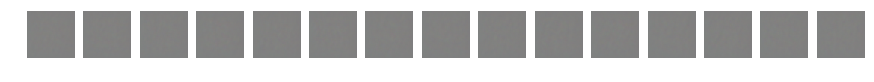

In [12]:
get_generator_samples()

### Train gan

In [13]:
fake_batches = image.ImageDataGenerator().flow_from_directory(
    '/data/fake_faces', 
    target_size=(64,64),
    class_mode=None, 
    shuffle=True, 
    batch_size=16
)

Found 13140 images belonging to 7 classes.


In [14]:
replay_images = []
fakes = fake_batches.next()
for i in range(fakes.shape[0]):
    replay_images.append(fakes[i])

In [15]:
from IPython import display

noise_level = 0.3

def plot_loss(losses):
        display.display(plt.gcf())
        plt.figure(figsize=(10,8))
        plt.yscale('log')
        plt.plot(losses["d"], label='discriminitive loss')
        plt.plot(losses["g"], label='generative loss')
        plt.legend()
        plt.show()

def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val


def real_batch(batch_size):
    result = train_batches.next()
    if len(result) < batch_size:
        result = train_batches.next()
    return result/256
    
def fake_batch(batch_size):
    return np.array(generator.predict(get_random_input_for_generator(batch_size)))

def replay_batch(batch_size):
    return np.array([replay_images[np.random.randint(0,len(replay_images))] for i in range(batch_size)])

def add_to_replay_images():
    replay_images.append(generator.predict(get_random_input_for_generator(1))[0])
    
def combined_discriminator_training_batch(fake_batch_size, replay_batch_size, real_batch_size):
    return np.concatenate((
        fake_batch(fake_batch_size), 
        replay_batch(replay_batch_size),
        real_batch(real_batch_size)
    ))
    
def label_noise_level(i):
    return pow(0.5, 1+i/1500)

def noisy_labels(zeros_size, ones_size):
    return np.concatenate((
        np.random.uniform(0, noise_level, zeros_size),
        np.random.uniform(1 - noise_level, 1, ones_size)
    ))

def train_discriminator_on_batch(training_images, training_labels):
    make_trainable(discriminator,True)
    return discriminator.train_on_batch(
        training_images, 
        training_labels
    )    
    

def train_discriminator_separately(batch_size):    
    loss2 = train_discriminator_on_batch(
        real_batch(batch_size),
        noisy_labels(0, batch_size)
    )
    
    loss3 = train_discriminator_on_batch(
        replay_batch(batch_size),
        noisy_labels(batch_size, 0)
    )
    
    loss4 = train_discriminator_on_batch(
        real_batch(batch_size),
        noisy_labels(0, batch_size)
    )
    
    loss1 = train_discriminator_on_batch(
        fake_batch(batch_size),
        noisy_labels(batch_size, 0)
    )
    
    return [
        (loss1[0] + loss2[0] + loss3[0] + loss4[0])/4,
        (loss1[1] + loss2[1] + loss3[1] + loss4[1])/4
    ]
    
    
def train_discriminator_combined(batch_size):    
    return train_discriminator_on_batch(
        combined_discriminator_training_batch(batch_size, batch_size, 2*batch_size),
        noisy_labels(2*batch_size, 2*batch_size)
    )
        
def train_generator(batch_size):
    prior_x = np.array(get_random_input_for_generator(2*batch_size))
    prior_labels = np.array([random.uniform(1-noise_level,1) for i in range(2*batch_size)])

    make_trainable(discriminator,False)
    return GAN.train_on_batch(prior_x, prior_labels)
        
def train_gan(epochs=5000, batch_size=32):   
    losses = {"d":[], "g":[]}
    preview_inputs = get_random_input_for_generator(15)
        
    last_d_loss = 1
    last_g_loss = 1
        
    for i in range(epochs):
        if i%500 == 0:
            lr = pow(10, -(5+i/500))
            noise_level = lr*3000
            
        if last_d_loss < last_g_loss:            
            opt.lr = lr
            dopt.lr = lr/2*(last_d_loss/last_g_loss)
        else:
            opt.lr = lr/2*(last_g_loss/last_d_loss)
            dopt.lr = lr
        
        #noise_level = label_noise_level(i)
        
        d_loss = train_discriminator_separately(batch_size)
        #d_loss = train_discriminator_combined(batch_size)
        
        g_loss = train_generator(batch_size)
        g_loss = train_generator(batch_size)
        g_loss = train_generator(batch_size)
        g_loss = train_generator(batch_size)
        
        losses['d'].append(d_loss[0])
        losses['g'].append(g_loss[0])
        
        last_d_loss = d_loss[0]
        last_g_loss = g_loss[0]
        
        add_to_replay_images()
        
        if i%10 == 0:
            display.clear_output(wait=True)
            plots(generator.predict(preview_inputs))
            plot_loss(losses)
            print(i, d_loss[0], g_loss[0], d_loss[1], g_loss[1], lr)

In [16]:
#for i in range(32):
#    add_to_replay_images()

Pretrain discriminator and generator

In [17]:
for i in range(300):
    d_loss = train_discriminator_separately(batch_size)
    
    if i%5 == 0:
        display.clear_output(wait=True)
        print(i, d_loss[0], d_loss[1])

295 0.43243470788 0.0


In [18]:
for i in range(50):
    g_loss = train_generator(batch_size)
    
    if i%5 == 0:
        display.clear_output(wait=True)
        print(i, g_loss[0], g_loss[1])

45 0.403963 0.0


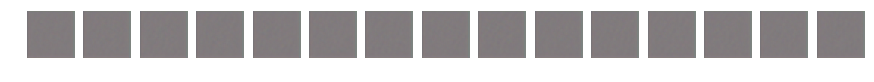

In [19]:
get_generator_samples()

Co-train them

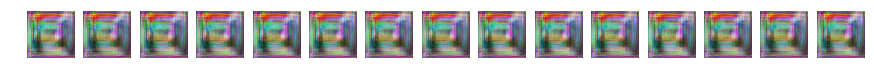

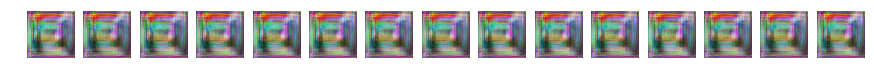

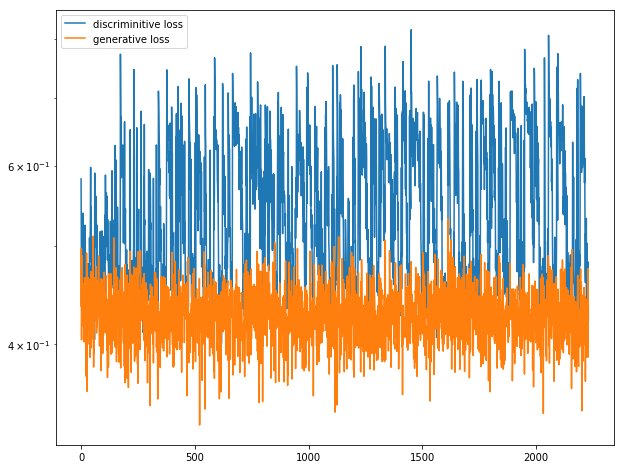

2230 0.428931176662 0.421728 0.0 0.0 1e-10


KeyboardInterrupt: 

In [20]:
train_gan(epochs=100000, batch_size=batch_size)

### Examine results

In [ ]:
get_generator_samples()

In [ ]:
GAN.predict(get_random_input_for_generator(8))

In [ ]:
discriminator.predict(mnist.train_input[np.random.randint(0,mnist.train_input.shape[0],size=8),:,:,:])

In [ ]:
print(len(replay_images))
plots([replay_images[i*math.floor(len(replay_images)/300)] for i in range(300)])

In [ ]:
plots(generator.predict(get_random_input_for_generator(150)))

In [ ]:
plots(generator.predict(get_random_input_for_generator(150,0.9)))

In [ ]:
generator.save_weights('/data/trained_models/mnist/gan/generator_v2.3.h5')
discriminator.save_weights('/data/trained_models/mnist/gan/discriminator_v2.3.h5')

In [ ]:
generator.load_weights('/data/trained_models/mnist/gan/generator_v2.2.h5')
discriminator.load_weights('/data/trained_models/mnist/gan/discriminator_v2.2.h5')

In [ ]:
import scipy.misc

In [ ]:
for i in range(6000, len(replay_images), 10):
    scipy.misc.imsave("/data/fake_faces/training_8/img_%06d.jpg"%(i+13170,), replay_images[i])
    

In [ ]:
generator.save_weights('/data/trained_models/face_gan/v8_generator_incomplete2.h5')
discriminator.save_weights('/data/trained_models/face_gan/v8_discriminator_incomplete2.h5')